# ARTS AMSR2 multi-FOV surface simulations

In [1]:
#  d duncan, 28/01/19
#  adapting a mixture of arts and matlab scripts from patrick to ipynb
#   so that i can play around with running the forward model before doing
#   any surface retrievals 

# this setup, in words:
### - define an antenna response that is frequency dependent, gaussian, symmetric
### - define sensor position and line of sight for each scan at middle of scan
### - define an angular grid (zenith & azimuth) for each scan that encompasses npix
### - sensor angles are all 'absolute' whereas the angular grid and antenna response 
###    are all relative to the central bore sight of the scan
### - a lat/lon grid is also defined that must encompass all observation points simulated
### - the same angular grid and simulation setup is assumed/copied for all nscans, and 
###    mblock_dlos_grid allows all simulations to be run at the same time

### *** this setup outputs simulated TBs for chosen channels of AMSR2
###    with antenna patterns taken into account and decoupled from any retrieval grid, with
###    pencil beam calculations sampling the antenna pattern according to the angular grid
###    defined

# number 2 refines the code to make plots correct, contains metmm calls but commented
#  out since definition of polarisation, angles, frequencies are done manually already

# NOTE: to get realistic-looking simulated TBs, the lat/lon and vertical grids need to be
#   of sufficient resolution because of the ray tracing methodology and the surface properties
#   are treated as an interpolation between lat/lon points to get the position at which yCalc
#   occurs. the angular grid resolution also can't be ignored but is quite dependent on the 
#   complexity of scene and the size of the FOV simulated.

In [2]:
fsub  = np.array([0,1,2,3,4,5,6])#,7]) # choose which frequencies to run (runs both polarisations--v/h)
#fsub  = np.array([0,5,6]) # choose which frequencies to run (runs both polarisations--v/h)

npix     =  21   # pixels across each scan considered
nscans   =  13   # consecutive scans considered
angfac   =   4   # angular samples per degree or between pix -- should be min ~10 (but depends on freqs used)
npol     =  2    # number of polarizations considered (2=V/H both, 1=intensity only)

In [3]:

%env ARTS_INCLUDE_PATH=/home/dudavid/arts/controlfiles/
%env ARTS_BUILD_PATH=/home/dudavid/arts/build/
%env ARTS_DATA_PATH=/home/dudavid/arts/arts-xml/ 

%matplotlib inline
#from h5py import File

from typhon.arts.workspace import Workspace, arts_agenda
ws = Workspace(verbosity=0)
ws.execute_controlfile("general/general.arts")
ws.execute_controlfile("general/continua.arts")
ws.execute_controlfile("general/agendas.arts")
ws.execute_controlfile("general/planet_earth.arts")

from typhon.arts.workspace.variables import *

ws.Copy( ws.abs_xsec_agenda, ws.abs_xsec_agenda__noCIA )
ws.Copy( ws.iy_main_agenda, ws.iy_main_agenda__Emission )
ws.Copy( ws.iy_space_agenda, ws.iy_space_agenda__CosmicBackground )
ws.Copy( ws.propmat_clearsky_agenda, ws.propmat_clearsky_agenda__OnTheFly )
ws.Copy( ws.ppath_agenda, ws.ppath_agenda__FollowSensorLosPath )
ws.Copy( ws.ppath_step_agenda, ws.ppath_step_agenda__GeometricPath )
@arts_agenda
def geo_pos_agendaPY(ws):
    ws.geo_posEndOfPpath()
ws.Copy( ws.geo_pos_agenda, geo_pos_agendaPY)  ## new one, set by patrick in his cfile

# define absorbing species and sensor (here using metmm library, used again below)
ws.abs_speciesSet(species=["H2O-PWR98","O2-PWR93","N2-SelfContStandardType"])#,"liquidcloud-ELL07"])
ws.abs_lines_per_speciesSetEmpty()

ws.stokes_dim = npol # to get V and H pol set to 2
ws.iy_unit = "PlanckBT" # equivalent: ws.StringSet( iy_unit, "PlanckBT" )

env: ARTS_INCLUDE_PATH=/home/dudavid/arts/controlfiles/
env: ARTS_BUILD_PATH=/home/dudavid/arts/build/
env: ARTS_DATA_PATH=/home/dudavid/arts/arts-xml/
Loading ARTS API from: /home/dudavid/arts/build/src/libarts_api.so


In [4]:
# Define lat/lon grid that observation points and angular grid lie within
lat0     = 0.0  # center of grid in lat, lon
lon0     = 0.0
nlat, nlon = 51, 51    # number of lat and lon divisions
latwid, lonwid = 1.5, 1.5  # just asssume square for now, widths double these
res = 2*latwid/nlat # assume equal in lat/lon for now
 
#lat_grid = lat0 + np.linspace(-latwid,latwid,nlat) # [-3:0.25:3]
lat_grid = lat0 + np.arange(-latwid,latwid+res,res)
lon_grid = lon0 + np.arange(-lonwid,lonwid+res,res)
 
ws.lat_grid = lat_grid[0:nlat]+np.diff(lat_grid)*.5 # to avoid mismatch between ARTS and pcolormesh
ws.lon_grid = lon_grid[0:nlon]+np.diff(lon_grid)*.5 #  i.e. getting lat/lon midpoints of boxes
#print(lon_grid)

In [5]:
print('corners of lat_grid: ',lat_grid)
print('midpoints of lat_grid (ARTS ws grid): ',lat_grid[0:nlat]+np.diff(lat_grid)*.5)

corners of lat_grid:  [-1.5        -1.44117647 -1.38235294 -1.32352941 -1.26470588 -1.20588235
 -1.14705882 -1.08823529 -1.02941176 -0.97058824 -0.91176471 -0.85294118
 -0.79411765 -0.73529412 -0.67647059 -0.61764706 -0.55882353 -0.5
 -0.44117647 -0.38235294 -0.32352941 -0.26470588 -0.20588235 -0.14705882
 -0.08823529 -0.02941176  0.02941176  0.08823529  0.14705882  0.20588235
  0.26470588  0.32352941  0.38235294  0.44117647  0.5         0.55882353
  0.61764706  0.67647059  0.73529412  0.79411765  0.85294118  0.91176471
  0.97058824  1.02941176  1.08823529  1.14705882  1.20588235  1.26470588
  1.32352941  1.38235294  1.44117647  1.5       ]
midpoints of lat_grid (ARTS ws grid):  [-1.47058824e+00 -1.41176471e+00 -1.35294118e+00 -1.29411765e+00
 -1.23529412e+00 -1.17647059e+00 -1.11764706e+00 -1.05882353e+00
 -1.00000000e+00 -9.41176471e-01 -8.82352941e-01 -8.23529412e-01
 -7.64705882e-01 -7.05882353e-01 -6.47058824e-01 -5.88235294e-01
 -5.29411765e-01 -4.70588235e-01 -4.11764706e-01 -3.

In [6]:
# set up atmosphere and surface variables:
ws.atmosphere_dim = 3  # 3D atmosphere
p = np.array([1015.,950.,800.])*100.0 #,650.,400.,100.])*100.0  # keep it simple, otherwise slower fwd model
#p = np.array([1015.,950.,850.,650.,400.,100.])*100.0  # keep it simple, otherwise slower fwd model
#p = np.array([1015.,975.,950.,925.,900.,850.,800.,750.,700.,650.,600.,550.,500.,400.,300.,200.,100.])*100.0
ws.p_grid = p[:] 
ws.AtmRawRead( basename = "planets/Earth/Fascod/tropical/tropical") #tropical atmosphere assumed
ws.AtmosphereSet3D()
ws.AtmFieldsCalcExpand1D()  # set to given p_grid or z_grid

#ws.vmr_field.value[:,:,:,:] *= 0.00 # try decreasing water vapor by X

# if using coarse atmosphere but wanting accurate ray tracing:
ws.ppath_lmax = 250.0  # set maximum distance between points when computing absorption along path

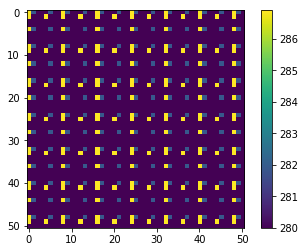

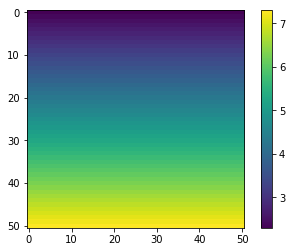

In [7]:
# Surface properties -- define ocean surface for simulations

nala, nalo = np.size(ws.lat_grid.value), np.size(ws.lon_grid.value) # size of ARTS lat/lon grid
s_names = ['Water skin temperature','Wind speed','Wind direction','Salinity']
s_data = np.zeros([len(s_names), nala, nalo])

tmean                   = 280.0 # sst mean
wsp                     = 2.3   # 10m wind speed
s_data[0,:,:] = tmean
#s_data[0,int(nlat/2)-1:int(nlat/2)+2,int(nlon/2)-1:int(nlon/2)+2] += 6
#s_data[0,:,::8] += 6.9  ## czechers
s_data[0,1::8,::4] += 6.9  ## czechers
s_data[0,0::4,::8] += 6.9  ## czechers
s_data[0,::4,1::4] += 1.9
#s_data[0,:,:] += np.tile(np.arange(0,nala),[nalo,1])
#s_data[0,18:21,18:21] = tmean +6.5 # some preturbation
#s_data[0,int(nlat/2),int(nlon/2)] = tmean +9.5 # some preturbation
s_data[1,:,:] = wsp
s_data[1,:,:] += .1*np.tile(np.arange(0,nalo),[nala,1]).transpose() 
s_data[2,:,:] = 90 # token wind direction value
s_data[3,:,:] = 0.034 # token salinity value

# write these to ARTS variables 
ws.Copy(ws.surface_props_names, s_names)
ws.Copy(ws.surface_props_data, s_data)
ws.MatrixSetConstant(ws.z_surface, nala, nalo, 0.0) # explicitly set the surface to 0m altitude

plt.imshow(s_data[0,:,:]) # quick look for SST
plt.colorbar()
plt.show()
plt.imshow(s_data[1,:,:])
plt.colorbar()
plt.show()

In [8]:
# Set and calculate some basic variables for antenna and scanning
### all will be replaced or superseded when moving to using L1R data as input
 
zsat   = 699.7e3      # Satellite altitde [m] -- can read this in later
vsat   = 6.76e3       # Satellite velocity [m/s]
dt     = 2.6e-3       # Integration time [s] -- 2.6ms for low freqs, 1.3ms for 89GHz
rpm    = 40           # Rotations per minute -- same for AMSR-E and AMSR2
 
# find nautical mile constant?  1852m = 1nmi
m2deg  = 1/(60*1852) #constants('NAUTICAL_MILE'))    # Conversion from m to latitude
dang   = dt * 360 * rpm / 60                  # Angular distance between samples
dlat   = m2deg * vsat * 60 / rpm              # Latitude distance between scans
print(dang,dlat)

0.624 0.09125269978401726


# Define antenna pattern

In [9]:

width  = 2.0           # Max half-width of antenna (if HPBW is 1.8deg, width=2 covers 2x the HPBW)
resol  = 0.01          # angular resolution (same in zenith/azimuth for now)
# for a given angular resolution (might vary), width=2 yields 99.96% of total power @6GHz 
#   compared to width=20 and 99.99999% @10GHz, width=1.5 yields 99.0 and 99.994.
#resol, width = dang/(angfac*5), awidth # set here instead of calling func
print('angular resolution of response grid [deg]: ',resol)

adata = [[ 6.925e9 ,  1.80],   # AMSR2 center frequency and beamwidth (deg)
         [ 7.300e9 ,  1.80],   # assumed the same for V/H polarizations
         [ 10.65e9 ,  1.20],
         [ 18.70e9 ,  0.65],
         [ 23.80e9 ,  0.75],
         [ 36.50e9 ,  0.35],
         [ 89.00e9 ,  0.15]] #,  # should be 0.15
         #[ 89.01e9 ,  1.50]]  # should be 0.15
#adata = [[ 6.600e9 ,  1.8],   # AMSR2 center frequency and beamwidth (deg)
#         [ 7.300e9 ,  1.8],   # assumed the same for V/H polarizations
#         [ 11.00e9 ,  1.2]] #,  ## changed to be greater than f_grid defined in metmm

adata = np.array(adata, order="C").transpose()[:,fsub] # choose selected frequencies (set above)
print(adata)

# define zenith, azimuth grid on the ground (relative to bore sight) -- assumed to be square, 2xWidth wide
x  = np.arange( -width, width+resol, resol )  #this gives angular antenna response points in za,aa
x2 = x**2   # since assumed origin is 0, do squaring here 
nf, nx = len(adata[0,:]), np.size(x)

csub = np.sort(np.append(fsub*2,fsub*2+1))
ch_str = np.array(['6V','6H','7V','7H','10V','10H','18V','18H',
                   '23V','23H','36V','36H','89V','89H','89Vw','89Hw'])[csub] # just chosen freqs
print(ch_str)

from typhon.arts.griddedfield import GriddedField4
gf4 = GriddedField4()
gf4.name = 'AMSR2 antenna response'
gf4.gridnames =  [ 'Polarisation', 'Frequency', 'Zenith angle', 'Azimuth angle' ]
###  note: za & aa are equally spaced, and we're treating V/H as having identical responses
if npol==2: gsp="1" 
else: gsp="0"
gf4.grids = [ [gsp], adata[0,:], x, x ]
gf4.dataname  = 'Response'
gf4.data      = np.zeros([ 1, nf, nx, nx ], order="C")
print('size of antenna_reponse grid: ',gf4.data.shape)

#blah = [4589.014643600229,
#4589.014643600229,
#2039.5620638223247]
for i in range(nf):
    si = adata[1,i] / (2*np.sqrt(2*np.log(2)))  # calculate standard deviation first, based on HPBW
    gf4.data[0,i,:,:] = np.exp( - np.tile(x2,[nx,1])/si**2 - np.tile(x2,[nx,1]).transpose()/ si**2 )
    #gf4.data[0,i,:,:] = np.exp( - (np.tile(x2,[nx,1]) + np.tile(x2,[nx,1]).transpose())/ si**2 ) # equivalent
    #print(np.sum(gf4.data[0,i,:,:])/blah[i])



angular resolution of response grid [deg]:  0.01
[[6.925e+09 7.300e+09 1.065e+10 1.870e+10 2.380e+10 3.650e+10 8.900e+10]
 [1.800e+00 1.800e+00 1.200e+00 6.500e-01 7.500e-01 3.500e-01 1.500e-01]]
['6V' '6H' '7V' '7H' '10V' '10H' '18V' '18H' '23V' '23H' '36V' '36H' '89V'
 '89H']
size of antenna_reponse grid:  (1, 7, 401, 401)


In [10]:

#plt.figure(figsize=[9,9])
#plt.pcolormesh(gf4.data[0,1,:,:])
#plt.colorbar()
#plt.figure(figsize=[9,9])
#plt.pcolormesh(gf4.data[0,2,:,:])
#plt.colorbar()
#plt.show()

In [11]:
# frequency grid of simulation is defined according to sensor setup above (may change with use of metmm)
f_grid = np.copy(gf4.grids[1])  # array with each frequency (not channel)

ws.f_grid.value = f_grid
print('f_grid: ',ws.f_grid.value)
 

f_grid:  [6.925e+09 7.300e+09 1.065e+10 1.870e+10 2.380e+10 3.650e+10 8.900e+10]


In [12]:
# Determine bore-sight angles to use for one scan 
 
# psteps defines the pixels across one scan
psteps   = np.arange(-(npix-1)/2, (npix-1)/2 +1, 1)  #  if npix is odd then middle boresight is in the middle
# ssteps defines position of spacecraft for each scan, evenly distributed around a middle scan
ssteps   = np.arange(-(nscans-1)/2, (nscans-1)/2 +1, 1) 
#print('pixel steps',psteps)

#  center line of sight... defined as AMSR2 EIA and 0 azimuth angle
los0    = [ 180-47.5, 0 ]  # 47.5 is off-nadir angle of AMSR2

# bsights defines the bore sight zenith and azimuth angles across the scan 
##-- just for one scan, assumed to be same for each scan?
bsights = np.array([ np.repeat(los0[0],npix), los0[1]+dang*psteps ]).transpose()  # size: [npix,2]
print('bsights:',(bsights[:,1]))

bsights: [-6.24  -5.616 -4.992 -4.368 -3.744 -3.12  -2.496 -1.872 -1.248 -0.624
  0.     0.624  1.248  1.872  2.496  3.12   3.744  4.368  4.992  5.616
  6.24 ]


In [13]:
# Define angular grid for pencilbeam calculations

# can use 'dang' or not, but benefit of using it is having RT calc at each boresight
#  in azimuth direction. if using 'dang' for zenith too then it's an evenly spaced angular grid.

n = np.floor( width * angfac )  # angular width * angular samples per deg
print(n)
za_grid = np.array( los0[0] +  np.arange(-n,n+1)/angfac)  ## effectively taking 'width' on either side of 0
#n = np.floor( angfac * width / dang )  # number per degree * angular width / distance between boresights
#za_grid = np.array( los0[0] + (dang/angfac) * np.arange(-n,n+1))  # zenith angle grid
print('zenith grid: ',za_grid) 

en = np.floor( angfac * ( bsights[-1,1] + width ) / dang ) # azimuth of boresight at edge +width
print(en)
aa_grid = np.array( los0[1] + (dang/angfac) * np.arange(-en,en+1))  # azimuth angle grid
#en = np.floor((bsights[-1,1]+width)*angfac) ## yields az from boresight at edge plus 'width' (could prob do width/2)
#aa_grid = np.array( los0[1] + np.arange(-en,en+1/angfac)/angfac)  # azimuth angle grid
print('azimuth grid: ',aa_grid) 


8.0
zenith grid:  [130.5  130.75 131.   131.25 131.5  131.75 132.   132.25 132.5  132.75
 133.   133.25 133.5  133.75 134.   134.25 134.5 ]
52.0
azimuth grid:  [-8.112 -7.956 -7.8   -7.644 -7.488 -7.332 -7.176 -7.02  -6.864 -6.708
 -6.552 -6.396 -6.24  -6.084 -5.928 -5.772 -5.616 -5.46  -5.304 -5.148
 -4.992 -4.836 -4.68  -4.524 -4.368 -4.212 -4.056 -3.9   -3.744 -3.588
 -3.432 -3.276 -3.12  -2.964 -2.808 -2.652 -2.496 -2.34  -2.184 -2.028
 -1.872 -1.716 -1.56  -1.404 -1.248 -1.092 -0.936 -0.78  -0.624 -0.468
 -0.312 -0.156  0.     0.156  0.312  0.468  0.624  0.78   0.936  1.092
  1.248  1.404  1.56   1.716  1.872  2.028  2.184  2.34   2.496  2.652
  2.808  2.964  3.12   3.276  3.432  3.588  3.744  3.9    4.056  4.212
  4.368  4.524  4.68   4.836  4.992  5.148  5.304  5.46   5.616  5.772
  5.928  6.084  6.24   6.396  6.552  6.708  6.864  7.02   7.176  7.332
  7.488  7.644  7.8    7.956  8.112]


In [14]:
# Set sensor_pos, sensor_los

ws.sensor_los = np.tile(los0, [nscans,1])  # sensor line of sight for each scan

shift   = 7.5    # Latitude shift to centre calculations around lat0

#### sensor_pos should be columns of altitude, SClat, SClon  ###  
####   so take all this from L1R files and transform X/Y/Z to lat/lon
# currently one alt/sclat/sclon for each scan (i.e. each of nscans)
ws.sensor_pos = np.hstack([np.repeat(zsat, nscans).reshape(nscans,1),
                          np.array(lat0 - shift + dlat * ssteps).reshape(nscans,1), 
                          np.repeat(lon0, nscans).reshape(nscans,1)])

print(ws.sensor_pos.value)
#print(np.transpose(ws.sensor_pos.value))
print(np.shape(ws.sensor_pos.value))


[[ 6.9970000e+05 -8.0475162e+00  0.0000000e+00]
 [ 6.9970000e+05 -7.9562635e+00  0.0000000e+00]
 [ 6.9970000e+05 -7.8650108e+00  0.0000000e+00]
 [ 6.9970000e+05 -7.7737581e+00  0.0000000e+00]
 [ 6.9970000e+05 -7.6825054e+00  0.0000000e+00]
 [ 6.9970000e+05 -7.5912527e+00  0.0000000e+00]
 [ 6.9970000e+05 -7.5000000e+00  0.0000000e+00]
 [ 6.9970000e+05 -7.4087473e+00  0.0000000e+00]
 [ 6.9970000e+05 -7.3174946e+00  0.0000000e+00]
 [ 6.9970000e+05 -7.2262419e+00  0.0000000e+00]
 [ 6.9970000e+05 -7.1349892e+00  0.0000000e+00]
 [ 6.9970000e+05 -7.0437365e+00  0.0000000e+00]
 [ 6.9970000e+05 -6.9524838e+00  0.0000000e+00]]
(13, 3)


In [15]:
# other controlfile things done in common.arts
ws.jacobianOff()
ws.cloudboxOff()

In [16]:
# define surface agenda:
varnam = ["Optical depth"]
ws.Copy(ws.iy_aux_vars, varnam)
ws.VectorCreate( "transmittance" )
#ws.transmittance = np.ones( ws.f_grid.value.shape ) * 0.0  #  FOR TESTING ONLY!!!!!
@arts_agenda
def iy_surface_agendaPY(ws):
    ws.specular_losCalc()
    # if wanting to test transmittance values, comment out next 3 calls and set outside agenda
    # if ppathCalc is called and uses assumed inputs, problems! so specify all!
    ws.ppathCalc(ws.ppath_agenda, ws.ppath_lmax, 
       ws.ppath_lraytrace, ws.atmgeom_checked, ws.t_field, ws.z_field, 
       ws.vmr_field, ws.f_grid, ws.cloudbox_on, ws.cloudbox_checked, 
       ws.ppath_inside_cloudbox_do, ws.rtp_pos, ws.specular_los, ws.rte_pos2 )
    ws.iyEmissionStandard()
    ws.transmittanceFromIy_aux(transmittance=ws.transmittance)
    ws.SurfaceFastem( transmittance = ws.transmittance, fastem_version=6 ) 
    ws.iySurfaceRtpropCalc()
    
ws.Copy(ws.iy_surface_agenda, iy_surface_agendaPY) # copy python-defined agenda to ARTS

# Use Metmm to set up sensor characteristics

In [17]:
#ws.sensor_los  = np.array([[180.0]]) # since angle taken care of in metmm file 
## zenith angle followed by azimuth. zenith=0 is straight up, 180 is straight down. azimuth=0 is N, positive to east 
#### NOTE that sensor_los should be overwritten below if using sensor and obs pos to determine LOS
#
#ws.ArrayOfIndexCreate("viewing_angles") # necessary if just using one pencil beam angle?
#ws.ArrayOfIndexCreate("channels")
#
#ws.IndexCreate("met_mm_accuracy") 
#ws.met_mm_accuracy = 2 # points within each bandwidth to comute abs characteristics
#
#csub = [0,1,2,3,4,5]  # channel subselection, defined in order given in metmm description
##ws.ArrayOfIndexCreate("viewing_angles_1")
##ws.viewing_angles_1 = [0] # index, defined in metmm file
##ws.ArrayOfIndexCreate("channels_1") # low freq channels EIA
#ws.channels = csub
#ws.Copy(ws.viewing_angles, [0])
##ws.Copy(ws.channels, ws.channels_1)
#
## re-execution of metmm control files ( since channels subset and angle have changed)
#ws.execute_controlfile("instruments/metmm/sensor_descriptions/prepare_metmm.arts")
#ws.execute_controlfile("instruments/metmm/sensor_descriptions/sensor_amsr2.arts") #atms.arts")
#ws.execute_controlfile("instruments/metmm/sensor_descriptions/apply_metmm.arts") # to execute CF?
#
#print(ws.sensor_los.value)
#print('f_grid: ',ws.f_grid.value)

In [18]:
# perform some checks:
ws.abs_xsec_agenda_checkedCalc()
ws.propmat_clearsky_agenda_checkedCalc()
ws.atmfields_checkedCalc( bad_partition_functions_ok = 1 )
ws.atmgeom_checkedCalc()
ws.cloudbox_checkedCalc()

In [19]:
# create vector mblock_reference_los and matrix mblock_target_los (to be used by DiffZaAa)
mblock_reference_los = np.array(los0)
print(mblock_reference_los)

# want to have all individual angle pairs distinct... so repeat one serially and one n times
mblock_target_los = np.array(np.transpose( np.stack( [ np.repeat(za_grid, aa_grid.size) , 
                                           np.tile(  aa_grid, za_grid.size) ]) ) , order = "C")
## need to specify 'C' order or else stride is wrong and array values are read wrong by ARTS

print(mblock_target_los.shape)

# use diffZaAa to convert reference frame in angle space
ws.DiffZaAa(ws.mblock_dlos_grid, mblock_reference_los, mblock_target_los)

print(np.shape(ws.mblock_dlos_grid.value))
print(np.diff(ws.mblock_dlos_grid.value[0:10,1]))
print(info(ws.mblock_dlos_grid.value[:,0]),info(ws.mblock_dlos_grid.value[:,1]))

[132.5   0. ]
(1785, 2)
(1785, 2)
[0.11814555 0.11816655 0.11818715 0.11820736 0.11822716 0.11824656
 0.11826555 0.11828415 0.11830233]
['-2.00E+0', '2.28E+0', '9.71E-2', '1.23E+0'] ['-6.16E+0', '6.16E+0', '0.00E+2', '3.48E+0']


In [20]:
### take commands from patrick's amsr2_cfile.arts
ws.VectorCreate("antenna_reference_los")
ws.MatrixCreate("antenna_target_los")
ws.antenna_reference_los = np.array(los0)
ws.antenna_target_los = np.array(bsights, order="C")
ws.DiffZaAa(ws.antenna_dlos, ws.antenna_reference_los, ws.antenna_target_los)

# define sensor... done above, but apply gf4 typhon/arts object to antenna_response:
ws.sensor_norm = 1
ws.antenna_dim = 2
ws.antenna_response = gf4 

###### TRYING TO READ IN A_r MANUALLY FOR TESTING:
#ws.ReadXML( ws.antenna_response, "/home/dudavid/Desktop/antenna_response.xml" ) 

#print('before sensor_response')
ws.sensor_responseInit()

## flipping from I/Q to V/H here... 
ws.instrument_pol = [5,6] # indices for V,H (1,2 are I,Q)
ws.sensor_responsePolarisation()

ws.sensor_responseAntenna()
#print('after sensor_response')
ws.sensor_checkedCalc()


# should this get called? not yet -- will give bsights from designated positions, draw a line 
#ws.sensor_losGeometricFromSensorPosToOtherPositions(ws.target_pos=np.array([]))

In [21]:
# after performing all the checks, run yCalc:

ws.yCalc()

In [22]:

# convert from stokes parameters to V/H-pol Tb
savey = np.copy(ws.y.value)
savey_vh = savey #np.zeros_like(savey)  # unnecessary now but eh
#for c in range(int(savey.size/2)):
#    #savey_vh[c*2]   = savey[c*2]+savey[c*2+1]  # V-pol = I+Q
#    #savey_vh[c*2+1] = savey[c*2]-savey[c*2+1]  # H-pol = I-Q
#    savey_vh[c*2]   = savey[c*2]    # I only -- but flipped to V/H by Polarisation command above
#    savey_vh[c*2+1] = savey[c*2+1]  # Q only


geo = np.copy(ws.y_geo.value)
print(np.shape(ws.y.value))
# y vector should be of size [nf*2 (stokes dim 2) ] * npix*nscans  

# vars coming out of yCalc should be in order, nch then npix then nscans, i.e.:
## with nch=6 first 6 values are from pix1,sc1 then next 6 are pix2,sc1 and so on -- be careful!

(3822,)


14 21 13
0.07892187910689853
0.3223763762114362
0.07723640458154389
0.3280816812743085
0.10718927803530039
0.35172166783763203
0.08585954112650565
0.48338793738501223
0.0712806193155434
0.49141356146045717
0.16744981385814495
0.6412586597390318
0.19123165570996717
0.4190276247338953
(3822,)


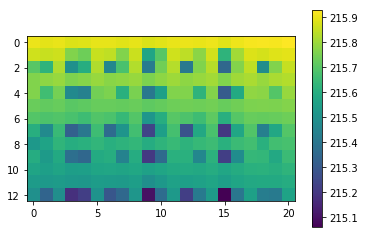

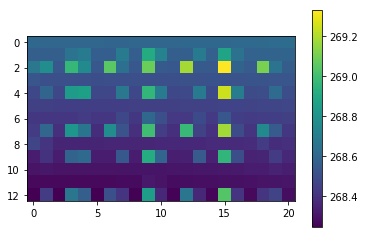

In [23]:
chan_tb = np.zeros([nscans,npix,nf*2]) #np.copy(ws.y.value[0::6])
arts_pos = np.zeros([nscans,npix,4]) #np.copy(ws.y.value[0::6])
print(nf*2,npix,nscans)
for c in range(nf*2):
    chan_tb[:,:,c] = savey_vh[c::nf*2].reshape(nscans,npix)
    #chan_tb[:,:,c] = savey_vh[c::nf*2].reshape(npix,nscans).transpose()
    print(np.std(savey_vh[c::nf*2]))
    for bb in range(4):
        arts_pos[:,:,bb] = geo[c::nf*2,bb+1].reshape(nscans,npix) ## arts obs points
        
    
print(np.shape(savey_vh))
#print(chan_tb[:,2,0])
plt.imshow(chan_tb[:,:,-4])
plt.colorbar()
plt.show()
#plt.imshow(chan_tb[:,:,1])
#plt.colorbar()
#plt.show()
plt.imshow(chan_tb[:,:,-2])
plt.colorbar()
plt.show()



In [24]:
geo = np.copy(ws.y_geo.value)
#print(np.shape(ws.y_geo.value))
print(info(geo[:,1]))
print(info(geo[:,2]))
print('geo obs points for first scan (lat/lon/za/aa): ')  # verified that's the data from first scan
#print(geo[:npix*nf*npol,1])  # columns are altitude, lat, lon, zenith, azimuth of measurement geoposition
#print(geo[:npix*nf*npol,2])  # columns are altitude, lat, lon, zenith, azimuth of measurement geoposition
#print(geo[:npix*nf*npol,3])  # columns are altitude, lat, lon, zenith, azimuth of measurement geoposition
#print(geo[:npix*nf*npol,4])  # note: zenith angles should be identical and be very close to EIA reported
# can compare [:,3] (az) to EIA from L1R (later), just 180-az to get EIA

['-6.90E-1', '4.48E-1', '-1.15E-1', '3.42E-1']
['-8.02E-1', '8.02E-1', '1.49E-17', '4.86E-1']
geo obs points for first scan (lat/lon/za/aa): 


In [25]:
widths  = np.array([35., 35., 24., 14., 15.,  7., 3.])[fsub] # in km across
heights = np.array([62., 62., 42., 22., 26., 12., 5.])[fsub] #  per freq, 6/7/10/18/23/36/89
#widths  = np.array([ 7., 35., 24., 14., 15.,  7., 3.,35])[fsub] # in km across
#heights = np.array([12., 62., 42., 22., 26., 12., 5.,62])[fsub] #  per freq, 6/7/10/18/23/36/89

# convert (roughly!) to deg near equator... okay as first approximation for plotting:
widths *= 360.0/40075.
heights*= 360.0/40075. # deg/circumference

### if wanting to get more exact with widths/heights of FOVs, can back out lat/lon differences
###  for edge of FOVs using positions with this package:
#from astropy import coordinates
#from astropy.coordinates import EarthLocation
#ploc = EarthLocation.from_geodetic(arts_pos[0,0,1],arts_pos[0,0,0], 0.0,ellipsoid='WGS84')
#ploc.
print('VERIFY THAT THESE ARE WHOLLY EVEN ON THE GRID!')
print(np.diff(arts_pos[0,:,1]))
print(np.diff(arts_pos[:,0,0]))

VERIFY THAT THESE ARE WHOLLY EVEN ON THE GRID!
[0.07996261 0.08004648 0.08012106 0.08018633 0.0802423  0.08028895
 0.08032627 0.08035427 0.08037294 0.08038228 0.08038228 0.08037294
 0.08035427 0.08032627 0.08028895 0.0802423  0.08018633 0.08012106
 0.08004648 0.07996261]
[0.09124375 0.09124375 0.09124375 0.09124375 0.09124376 0.09124376
 0.09124376 0.09124376 0.09124376 0.09124376 0.09124376 0.09124375]


(273,)


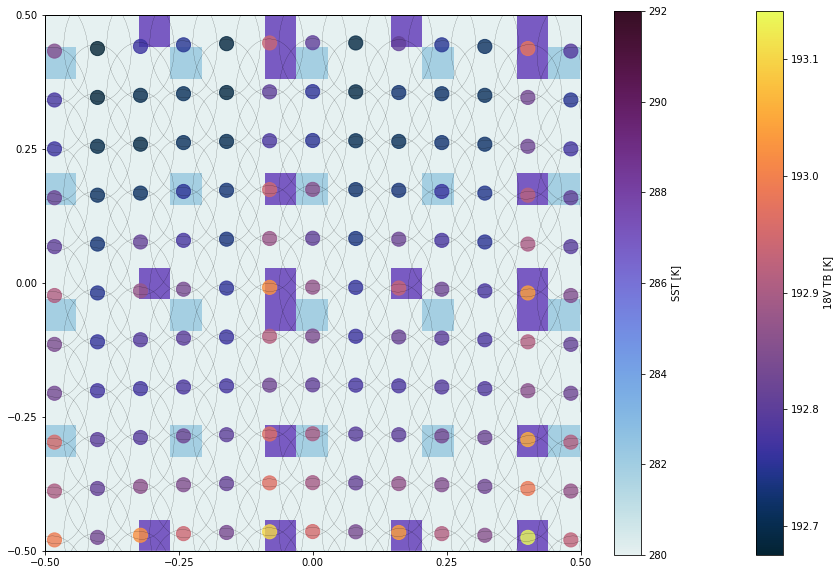

In [30]:
# plotting representative ellipses:
from matplotlib.patches import Ellipse
from cartopy import crs as ccrs
from cmocean import cm as cmo

# provide x,y coords, width, height, angle of ellipse

k=  6 #nf*2-2

ells = [Ellipse(xy=[arts_pos[i,j,1],arts_pos[i,j,0]], width=widths[int(k/2)], height=heights[int(k/2)], 
                angle=-arts_pos[i,j,3], linewidth=0.2, alpha=0.7, fill=False) 
        for i in range(nscans) for j in range(npix)]# for k in [0]] #range(nf*2)]
print(np.shape(ells))

#ax.fill(x, y, alpha=0.2, facecolor='yellow',
#        edgecolor='yellow', linewidth=1, zorder=1)
#ax.add_patch()

fig = plt.figure(figsize=[15,10])
projj = ccrs.PlateCarree()
ax = plt.subplot(111, projection=projj )

inn =  1.0#.7 #-0.3 # zoom in by x degrees from edges of lat/lon grid
#reg = [np.min(arts_pos[:,:,0])+inn, np.max(arts_pos[:,:,0])-inn,
#       np.min(arts_pos[:,:,1])+inn, np.max(arts_pos[:,:,1])-inn]
reg = [np.min(lat_grid)+inn, np.max(lat_grid)-inn,
       np.min(lon_grid)+inn, np.max(lon_grid)-inn]
ax.set_xlim(left=reg[2], right=reg[3])
ax.set_ylim(bottom=reg[0], top=reg[1])
nx,ny = 5,5
ax.set_xticks( np.linspace(reg[2],reg[3], nx) )
ax.set_yticks( np.linspace(reg[0],reg[1], ny) )

#thenorm1=plt.Normalize(vmin=tmean-5,vmax=tmean+5)
thenorm1=plt.Normalize(vmin=tmean,vmax=tmean+12)
#thenorm1 = plt.Normalize(vmin=wsp,vmax=wsp+12)
ceem1=cmo.dense
#bb= ax.pcolormesh(lon_grid,lat_grid,s_data[1,:,:],norm=thenorm1, # so windspeed
bb= ax.pcolormesh(lon_grid,lat_grid,s_data[0,:,:],norm=thenorm1, # so SST
             transform=projj, cmap=ceem1)


#for e in ells[::nf*2][-npix:-1]:  # so just 6V right now
for e in ells[:]: 
    ax.add_artist(e)

vmin=np.min(chan_tb[:,:,k]) #-.5
vmax=np.max(chan_tb[:,:,k]) #+.5
thenorm=plt.Normalize(vmin=vmin,vmax=vmax)
#print(chan_tb[-1,:,0])
#print(arts_pos[-1,:,1])
ceem = cmo.thermal
#ax.scatter( arts_pos[-1,:,1], arts_pos[-1,:,0], s=90.0, c=chan_tb[-1,:,0], marker='o', \
ax.scatter( arts_pos[:,:,1], arts_pos[:,:,0], s=200.0, c=chan_tb[:,:,k], marker='o', \
            transform=projj, alpha=0.8, cmap=ceem, norm=thenorm);
sm = plt.cm.ScalarMappable(cmap=ceem, norm=thenorm)
sm._A = []
cb = plt.colorbar(sm,ax=ax)
cb.set_label(ch_str[k]+' TB [K]')
sm1 = plt.cm.ScalarMappable(cmap=ceem1, norm=thenorm1)
sm1._A = []
cb1 = plt.colorbar(sm1,ax=ax)
cb1.set_label('SST [K]')

plt.savefig('img/example_syn_scene_'+ch_str[k]+'_v3-p1.png',bbox_inches='tight',dpi=350)
plt.show()

In [27]:
print(chan_tb[0,:,-2])
print(chan_tb[0,:,-4])
print(chan_tb[0,:,0])
#print(chan_tb[:,0,4])
#print(arts_pos[:,0,1])
#[273.77061023 273.7661729  273.59815148 273.36525153 273.15085353
# 273.05629686 273.15152161 273.36659835 273.60019053 273.76890783
# 273.7740211 ]
#[273.86809792 273.85578193 273.61010413 273.36261765 273.11151305
# 272.87441512 273.1121749  273.36395784 273.61213913 273.85852811
# 273.87153199]
#[164.22867613 164.21104754 163.69125257 162.92997561 162.24141727 # 6V angfac=1
# 161.95451021 162.24154772 162.93023732 163.69164643 164.21157358
# 164.22933239
satp
print(lon_grid.size, s_data[0,0,:].size)
print(chan_tb[:,1,0])
print(chan_tb[:,6,0])

[268.6057587  268.60407445 268.60279369 268.60175409 268.60081581
 268.60054135 268.60015672 268.60021098 268.60057563 268.60147698
 268.6021913  268.60361037 268.60483853 268.60659507 268.60864969
 268.61112684 268.61347346 268.61645927 268.61951828 268.62278617
 268.62642118]
[215.90326427 215.89234295 215.89901594 215.88231213 215.88548702
 215.8964013  215.89643383 215.89017577 215.89677611 215.87988303
 215.88913786 215.90053106 215.902033   215.89801948 215.90667319
 215.889287   215.90436116 215.9162039  215.91933397 215.91498104
 215.92776307]
[158.90267484 158.90955295 158.96817063 159.05747017 159.04704891
 158.94125739 158.8917613  158.90860014 158.98137377 159.07809078
 159.04912898 158.93743587 158.8980839  158.91753505 158.99091315
 159.06978664 159.0202099  158.9188961  158.89881567 158.94774581
 159.06033176]


NameError: name 'satp' is not defined

In [ ]:
for c in range(nf*2):
    print(info(chan_tb[:,:,c]))

In [ ]:
# to run fastem alone for testing, outputting emissivities and expected TBs with no atmosphere:
#ws.MatrixCreate("emissivity")
#ws.MatrixCreate("reflectivity")
#ws.reflectivity = np.zeros([f_grid.size,4])
#ws.emissivity   = np.zeros([f_grid.size,4])
##ws.surface_skin_t = tmean #s_data[0,:,:]
##ws.transmittance
#ws.transmittance = np.ones( ws.f_grid.value.shape ) * 0.7
#yep = 34
#emii = np.zeros([yep,nf,2])
#tbout= np.zeros([yep,nf,2])
#tmean=270.0
#for y in range(yep):
#    ws.surface_skin_t = tmean+float(y) #s_data[0,:,:]
#    ws.FastemStandAlone(surface_skin_t= tmean+y, f_grid=ws.f_grid,
#                        emissivity=ws.emissivity, reflectivity=ws.reflectivity,
#                        za=125.0, wind_speed=wsp, rel_aa=0.0, transmittance=ws.transmittance.value)
#    emii[y,:,:] = ws.emissivity.value[:,0:2]
#    tbout[y,:,:]= ws.emissivity.value[:,0:2]*tmean+y

In [ ]:
#### soooo, emissivity varies quite little with temperature for 6V (0.557->.553->.56),
#     declines slightly at 18 (.64->.58), then bigtime at 89 (.84->.74)
##print(ws.emissivity.value)
#print(emii[:,0,0]) # 6
##print(emii[:,3,0]) # 18
##print(emii[:,5,0]) # 36
#print(emii[:,-1,0]) # 89
#
#print(tbout[:,1,0])
##print(tbout[:,2,0])
#print(tbout[:,-1,0])

In [ ]:
# 89v @ 1.85
#[273.72615686 273.71760372 273.57292552 273.3606657  273.17057684
# 273.09250485 273.17124776 273.3620163  273.5749662  273.72033496
# 273.72954625]
# 89v @ 0.15:
#[273.86979114 273.85747958 273.6117788  273.36426764 273.11314323
# 272.8765316  273.11380517 273.365608   273.61381406 273.8602261
# 273.87322565]
# wider (2.85)
#[273.6516068  273.62084672 273.5203548  273.37442949 273.24786706
# 273.20250121 273.24854328 273.37578509 273.52239188 273.62355689
# 273.65488803]
# narrower (0.10)
#[273.87270627 273.86039058 273.61468859 273.36717793 273.11604303
# 272.87002825 273.11670467 273.36851773 273.61672301 273.86313602
# 273.87613952]